RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [89]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier
import json

In [90]:
# Categories of interest = {"Generic policy", "Reporting mechanism", "Scope of practice", "User guideline"}

selected_categories = 'User guideline'

# Load datasets
df_train = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_train.json')
df_val = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_val.json')
df_test = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_test.json')

#scale up the dataset
df_train = pd.concat([df_train, df_train])
# df_val = pd.concat([df_val, df_val])
# df_test = pd.concat([df_test, df_test])

In [91]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Project practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)

        
# Features
selected_features = ['num_stargazers', 'num_subscribers', 'num_watchers']

# activeness = 'num_commits', 'project_age_days', 'num_issues', 'num_pull'
# popularity = 'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers'
# metadata = 'num_contributors', 'project_size(kB)'
# security_practice = Openssf scorecard score -> แค่ 10 practices
# project_quality = sonarQube report


# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train[selected_categories]
X_val, y_val = df_val[selected_features], df_val[selected_categories]
X_test, y_test = df_test[selected_features], df_test[selected_categories]

# print(y_train.value_counts())
# print(y_val.value_counts())
# print(y_test.value_counts())

In [92]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Check class distribution before oversampling
print("Before SMOTE:")
print(y_train.value_counts())
# print(y_val.value_counts())
# print(y_test.value_counts())

# Apply SMOTE to balance classes in training data
smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)  # Keep a slight imbalance
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
# X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Check class distribution after oversampling
print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
# print(pd.Series(y_val_resampled).value_counts())
# print(pd.Series(y_test_resampled).value_counts())


Before SMOTE:
User guideline
0    360
1     62
Name: count, dtype: int64

After SMOTE:
User guideline
0    360
1    360
Name: count, dtype: int64


In [93]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


In [94]:
# Compute average classification reports
def average_classification_report(reports):
    avg_report = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):  # Normal classification labels
            avg_report[label] = {
                metric: np.mean([r[label][metric] for r in reports]) for metric in reports[0][label]
            }
        else:  # Handle 'accuracy' separately (it's a float)
            avg_report[label] = np.mean([r[label] for r in reports])
    return avg_report

Random forest Classification

best parameter: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/ 
and https://tahera-firdose.medium.com/fine-tuning-your-random-forest-classifier-a-guide-to-hyperparameter-tuning-d5ceab0c4852

In [95]:
# Train Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.78
Validation Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        51
           1       0.17      0.11      0.13         9

    accuracy                           0.78        60
   macro avg       0.51      0.51      0.50        60
weighted avg       0.75      0.78      0.76        60

Test Accuracy: 0.77
Test Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.00      0.00      0.00         5

    accuracy                           0.77        31
   macro avg       0.41      0.46      0.44        31
weighted avg       0.69      0.77      0.73        31



In [96]:
# Define the classifier
rf_clf = RandomForestClassifier()

# Store classification reports and accuracies
val_reports = []
test_reports = []
val_accuracies = []
test_accuracies = []

# Run the model 10 times
for _ in range(100):
    rf_clf.fit(X_train, y_train)
    
    # Validation
    y_val_pred = rf_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    val_reports.append(val_report)
    
    # Testing
    y_test_pred = rf_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_reports.append(test_report)

avg_val_report = average_classification_report(val_reports)
avg_test_report = average_classification_report(test_reports)

# Convert results to DataFrame for visualization
df_val_report = pd.DataFrame(avg_val_report).T
df_test_report = pd.DataFrame(avg_test_report).T

print('val Report:')
print(df_val_report)


print('test Report:')
print(df_test_report)

val Report:
              precision    recall  f1-score    support
0              0.850910  0.895490  0.872585  51.000000
1              0.160440  0.111111  0.130798   9.000000
accuracy       0.777833  0.777833  0.777833   0.777833
macro avg      0.505675  0.503301  0.501692  60.000000
weighted avg   0.747339  0.777833  0.761317  60.000000
test Report:
              precision    recall  f1-score    support
0              0.824200  0.901923  0.861246  26.000000
1              0.000000  0.000000  0.000000   5.000000
accuracy       0.756452  0.756452  0.756452   0.756452
macro avg      0.412100  0.450962  0.430623  31.000000
weighted avg   0.691264  0.756452  0.722335  31.000000


100%|██████████| 31/31 [00:00<00:00, 188.45it/s]


Text(0.5, -0.577777777777781, 'SHAP value')

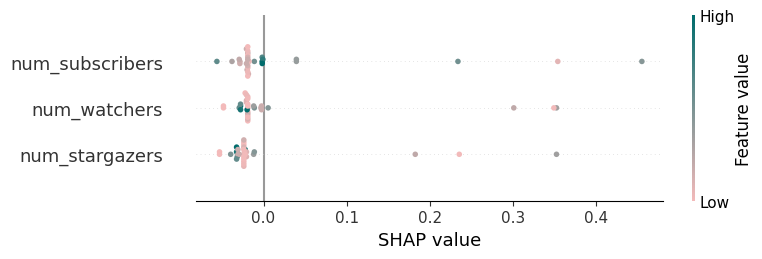

In [97]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

XGBoost Classification

params: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

In [98]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [200, 300, 500],
#     "max_depth": [3, 4, 5],
#     "learning_rate": [0.01, 0.03, 0.05],
#     "min_child_weight": [3, 5, 7],
#     "gamma": [1, 3, 5]
# }

# grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)

# print("Best Parameters:", grid_search.best_params_)


In [99]:
#n_estimators=500, max_depth=8, learning_rate=0.05, colsample_bytree=0.8, subsample=0.8
xg_clf = XGBClassifier()
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.83
Validation Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91        51
           1       0.40      0.22      0.29         9

    accuracy                           0.83        60
   macro avg       0.64      0.58      0.60        60
weighted avg       0.80      0.83      0.81        60

Test Accuracy: 0.74
Test Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        26
           1       0.00      0.00      0.00         5

    accuracy                           0.74        31
   macro avg       0.41      0.44      0.43        31
weighted avg       0.69      0.74      0.71        31



In [100]:
# Define the XGBoost classifier with specified parameters
xg_clf = XGBClassifier()

# Store classification reports and accuracies
xgb_val_reports = []
xgb_test_reports = []
xgb_val_accuracies = []
xgb_test_accuracies = []

# Run the model 10 times
for _ in range(100):
    xg_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = xg_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    xgb_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    xgb_val_reports.append(val_report)

    # Testing
    y_test_pred = xg_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    xgb_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    xgb_test_reports.append(test_report)

# Compute average classification reports
avg_xgb_val_report = average_classification_report(xgb_val_reports)
avg_xgb_test_report = average_classification_report(xgb_test_reports)

# Convert results to DataFrame for visualization
df_xgb_val_report = pd.DataFrame(avg_xgb_val_report).T
df_xgb_test_report = pd.DataFrame(avg_xgb_test_report).T

print('val Report:')
print(df_xgb_val_report)

print('test Report:')
print(df_xgb_test_report)

val Report:
              precision    recall  f1-score    support
0              0.872727  0.941176  0.905660  51.000000
1              0.400000  0.222222  0.285714   9.000000
accuracy       0.833333  0.833333  0.833333   0.833333
macro avg      0.636364  0.581699  0.595687  60.000000
weighted avg   0.801818  0.833333  0.812668  60.000000
test Report:
              precision    recall  f1-score    support
0              0.821429  0.884615  0.851852  26.000000
1              0.000000  0.000000  0.000000   5.000000
accuracy       0.741935  0.741935  0.741935   0.741935
macro avg      0.410714  0.442308  0.425926  31.000000
weighted avg   0.688940  0.741935  0.714456  31.000000


Text(0.5, -0.577777777777781, 'SHAP value')

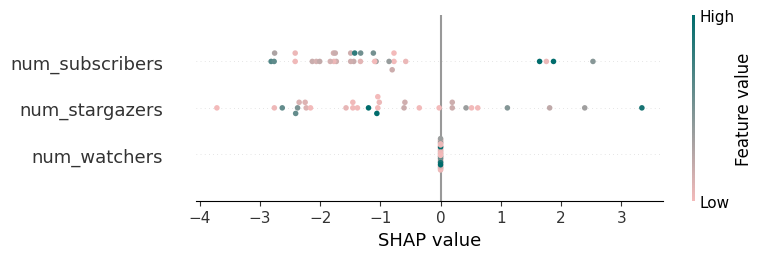

In [101]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

NN MLPClassifier

In [102]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.87
Validation Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        51
           1       1.00      0.11      0.20         9

    accuracy                           0.87        60
   macro avg       0.93      0.56      0.56        60
weighted avg       0.88      0.87      0.82        60

Test Accuracy: 0.84
Test Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [103]:
# Define the MLP classifier
mlp_clf = MLPClassifier()

# Store classification reports and accuracies
mlp_val_reports = []
mlp_test_reports = []
mlp_val_accuracies = []
mlp_test_accuracies = []

# Run the model 10 times
for _ in range(100):
    mlp_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = mlp_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    mlp_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    mlp_val_reports.append(val_report)

    # Testing
    y_test_pred = mlp_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mlp_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    mlp_test_reports.append(test_report)

# Compute average classification reports
avg_mlp_val_report = average_classification_report(mlp_val_reports)
avg_mlp_test_report = average_classification_report(mlp_test_reports)

# Convert results to DataFrame for visualization
df_mlp_val_report = pd.DataFrame(avg_mlp_val_report).T
df_mlp_test_report = pd.DataFrame(avg_mlp_test_report).T

print('val Report:')
print(df_mlp_val_report)

print('test Report:')
print(df_mlp_test_report)

c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

val Report:
              precision    recall  f1-score  support
0              0.852161  1.000000  0.920172  51.0000
1              0.150000  0.016667  0.030000   9.0000
accuracy       0.852500  0.852500  0.852500   0.8525
macro avg      0.501081  0.508333  0.475086  60.0000
weighted avg   0.746837  0.852500  0.786646  60.0000
test Report:
              precision   recall  f1-score   support
0              0.838710  1.00000  0.912281  26.00000
1              0.000000  0.00000  0.000000   5.00000
accuracy       0.838710  0.83871  0.838710   0.83871
macro avg      0.419355  0.50000  0.456140  31.00000
weighted avg   0.703434  0.83871  0.765139  31.00000


c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

100%|██████████| 31/31 [00:00<00:00, 663.28it/s]


Text(0.5, -0.577777777777781, 'SHAP value')

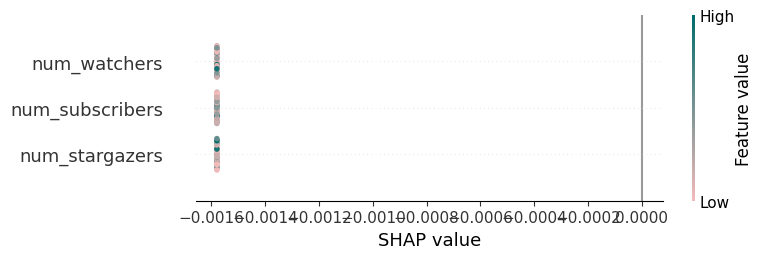

In [104]:
# Shap MLP
explainer = shap.KernelExplainer(mlp_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"SHAP value")

Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Validate LR
y_val_pred = lr_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test LR
y_test_pred = lr_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.85
Validation Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        51
           1       0.00      0.00      0.00         9

    accuracy                           0.85        60
   macro avg       0.42      0.50      0.46        60
weighted avg       0.72      0.85      0.78        60

Test Accuracy: 0.84
Test Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Decision Trees

In [106]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# # Define parameter grid
# param_grid = {
#     'max_depth': [2, 4, 6, 8, 10, None],  # Tree depth
#     'min_samples_split': [2, 5, 10, 20],  # Min samples to split a node
#     'min_samples_leaf': [1, 2, 5, 10]  # Min samples in leaf
# }

# # Initialize Decision Tree
# dt_clf = DecisionTreeClassifier(random_state=42)

# # Grid Search CV (Exhaustive)
# grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Randomized Search CV (Faster)
# random_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
# random_search.fit(X_train, y_train)

# # Best parameters from each search
# best_params_grid = grid_search.best_params_
# best_params_random = random_search.best_params_

# # Best score from each search
# best_score_grid = grid_search.best_score_
# best_score_random = random_search.best_score_

# # Print Results
# print("Best Parameters (Grid Search):", best_params_grid)
# print("Best Validation Accuracy (Grid Search):", best_score_grid)

# print("\nBest Parameters (Randomized Search):", best_params_random)
# print("Best Validation Accuracy (Randomized Search):", best_score_random)

# # Use the best model
# best_model = grid_search.best_estimator_


In [107]:
from sklearn.tree import DecisionTreeClassifier

# max_depth=2, random_state=42
dt_clf = DecisionTreeClassifier(ccp_alpha=0.01,)
dt_clf.fit(X_train, y_train)

# Validate DT
y_val_pred = dt_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test DT
y_test_pred = dt_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.87
Validation Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        51
           1       1.00      0.11      0.20         9

    accuracy                           0.87        60
   macro avg       0.93      0.56      0.56        60
weighted avg       0.88      0.87      0.82        60

Test Accuracy: 0.84
Test Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Beebie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [108]:

# Store classification reports and accuracies
dt_val_reports = []
dt_test_reports = []
dt_val_accuracies = []
dt_test_accuracies = []

# Run the model multiple times
for _ in range(100):
    dt_clf = DecisionTreeClassifier(min_samples_leaf= 1)
    dt_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = dt_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    dt_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    dt_val_reports.append(val_report)

    # Testing
    y_test_pred = dt_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    dt_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    dt_test_reports.append(test_report)

avg_dt_val_report = average_classification_report(dt_val_reports)
avg_dt_test_report = average_classification_report(dt_test_reports)

# Convert results to DataFrame for visualization
df_dt_val_report = pd.DataFrame(avg_dt_val_report).T
df_dt_test_report = pd.DataFrame(avg_dt_test_report).T

print('Average Validation Report:')
print(df_dt_val_report)

print('\nAverage Test Report:')
print(df_dt_test_report)


Average Validation Report:
              precision    recall  f1-score    support
0              0.877551  0.843137  0.860000  51.000000
1              0.272727  0.333333  0.300000   9.000000
accuracy       0.766667  0.766667  0.766667   0.766667
macro avg      0.575139  0.588235  0.580000  60.000000
weighted avg   0.786827  0.766667  0.776000  60.000000

Average Test Report:
              precision    recall  f1-score    support
0              0.827586  0.923077  0.872727  26.000000
1              0.000000  0.000000  0.000000   5.000000
accuracy       0.774194  0.774194  0.774194   0.774194
macro avg      0.413793  0.461538  0.436364  31.000000
weighted avg   0.694105  0.774194  0.731965  31.000000


Support Vector Machine (SVM)

In [109]:
# from sklearn.svm import SVC

# svm_clf = SVC(kernel='linear')
# svm_clf.fit(X_train, y_train)

# # Validate DT
# y_val_pred = svm_clf.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f'Validation Accuracy: {val_accuracy:.2f}')
# print('Validation Report:')
# print(classification_report(y_val, y_val_pred))

# # Test DT
# y_test_pred = svm_clf.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f'Test Accuracy: {test_accuracy:.2f}')
# print('Test Report:')
# print(classification_report(y_test, y_test_pred))

k-Nearest Neighbors

In [110]:
from sklearn.neighbors import KNeighborsClassifier

# n_neighbors=3
KN_clf = KNeighborsClassifier()
KN_clf.fit(X_train, y_train)

# Validate DT
y_val_pred = KN_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test DT
y_test_pred = KN_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.78
Validation Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        51
           1       0.17      0.11      0.13         9

    accuracy                           0.78        60
   macro avg       0.51      0.51      0.50        60
weighted avg       0.75      0.78      0.76        60

Test Accuracy: 0.81
Test Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        26
           1       0.00      0.00      0.00         5

    accuracy                           0.81        31
   macro avg       0.42      0.48      0.45        31
weighted avg       0.70      0.81      0.75        31

